# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

In [ ]:
# set up path to doogle drive folder with weights
weights_path = '/content/drive/MyDrive/Uni/MA/model_weights/'

##### Notebook settings

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [ ]:
!pip -q install git+https://github.com/tensorflow/privacy

##### Import libraries

In [ ]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, Input, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.analysis.compute_noise_from_budget_lib import compute_noise
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasAdamOptimizer

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SingleAttackResult
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [ ]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
780MB [00:06, 123MB/s] 


##### Define constants

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
TEST_SPLIT = 0.15
VAL_SPLIT = 0.05
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 16
IMG_SHAPE = [256, 256, 3] # original dataset image size is 299x299x3
EPOCHS = 20

# DP-SGD parameters
NOISE_MULTIPLIER = 1.023
L2_NORM_CLIP = 1.0
MICROBATCHES = BATCH_SIZE

# Set fixed random seed
SEED = 42
random.seed(SEED)
random_state = SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data


### Create dataset

In [ ]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [ ]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [ ]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [ ]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [ ]:
# create train-val-test split with 80-5-15
x_train, x_rest, y_train, y_rest = train_test_split(files, labels, test_size=VAL_SPLIT+TEST_SPLIT, random_state=random_state)
x_test, x_val, y_test, y_val = train_test_split(x_rest, y_rest, test_size=VAL_SPLIT/(VAL_SPLIT+TEST_SPLIT), random_state=random_state)

In [ ]:
TRAIN_IMG_COUNT = len(y_train)
VAL_IMG_COUNT = len(y_val)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 7232, Val: 452, Test: 1356


In [ ]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [ ]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set: ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 4339, 'COVID-19': 2893}
val set:  {'normal': 272, 'COVID-19': 180}
test set:   {'normal': 813, 'COVID-19': 543}


###### Create tensors

In [ ]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [ ]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [ ]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing

In [ ]:
preprocessing = Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

###### Define data augmentation

In [ ]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [ ]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [ ]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [ ]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [ ]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=True,
                                cache='./data.tfcache')
val_batched = prepare_dataset(val_ds,
                              pre=True,
                              shuffle=False,
                              repeat=False,
                              batch=True,
                              augment=False)
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [ ]:
# set for attack on train set
train_attack_data = prepare_dataset(train_ds,
                                    pre=True,
                                    shuffle=False,
                                    repeat=False,
                                    batch=1,
                                    augment=False,
                                    cache=False)

# set for attack on test set
test_attack_data = prepare_dataset(test_ds,
                                   pre=True,
                                   shuffle=False,
                                   repeat=False,
                                   batch=1,
                                   augment=False,
                                   cache=False)

### Visualization

###### Distribution of labels in the sets

In [ ]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

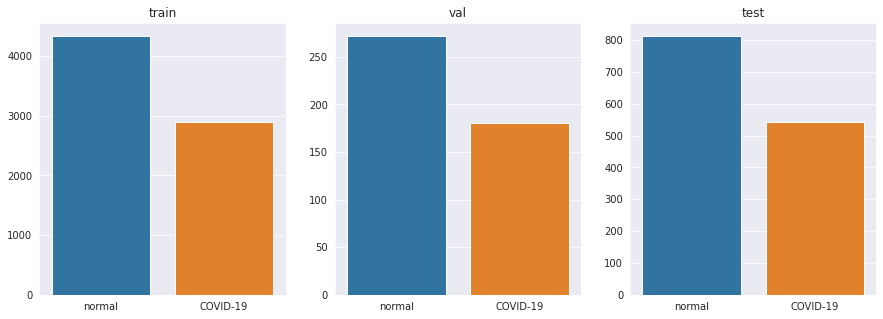

In [ ]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [ ]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


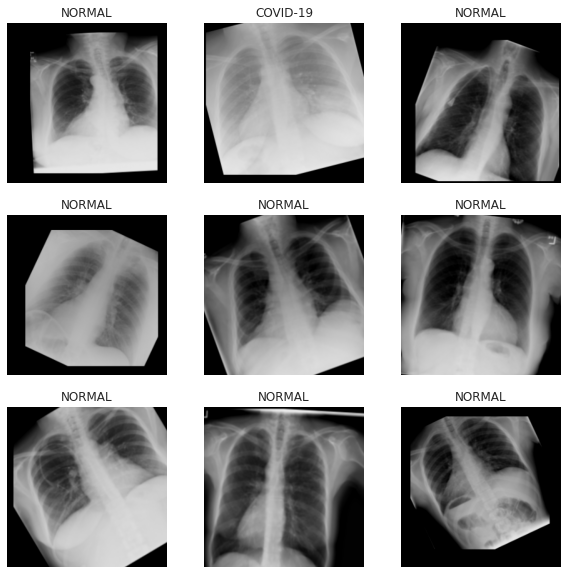

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [ ]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

## ResNet18V2 relu
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    preact = BatchNormalization(epsilon=1.001e-5, name=name + '_preact_bn')(x)
    preact = Activation('relu', name=name + '_preact_relu')(preact)
    if conv_shortcut is True:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = MaxPooling2D(1, strides=stride)(x) if stride > 1 else x
    x = Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_relu')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_relu')(x)
    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = Add(name=name + '_out')([shortcut, x])
    return x

def resnet_stack(x, filters, blocks, stride1=2, name=None):
    x = resnet_block(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = resnet_block(x, filters, name=name + '_block' + str(i))
    x = resnet_block(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet(stack_fn, input, model_name='resnet'):
    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(input)
    x = Conv2D(64, 7, strides=2, use_bias=True, name='conv1_conv')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = MaxPooling2D(3, strides=2, name='pool1_pool')(x)
    x = stack_fn(x)
    x = BatchNormalization(epsilon=1.001e-5, name='post_bn')(x)
    x = Activation('relu', name='post_relu')(x)
    # Create model.
    model = tf.keras.models.Model(input, x, name=model_name)
    return model

def ResNet18V2(input):
    def stack_fn(x):
        x = resnet_stack(x, 16, 2, name='conv2') # original: 64
        x = resnet_stack(x, 32, 2, name='conv3')
        x = resnet_stack(x, 64, 2, name='conv4')
        x = resnet_stack(x, 128, 2, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, input, 'resnet18v2')

In [ ]:
def resnet18_relu_builder():
    # ResNet18V2 without head
    resnet18 = ResNet18V2(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])))
    model = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        resnet18, # add resnet18 to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet18V2-relu')
    
    return model

In [ ]:
resnet18_relu = resnet18_relu_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet18_relu.compile(
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [ ]:
resnet18_relu.summary()

Model: "ResNet18V2-relu"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_6 (ModuleWrap (None, 8, 8, 512)         897088    
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 513       
Total params: 897,601
Trainable params: 891,713
Non-trainable params: 5,888
_________________________________________________________________


### Training

In [ ]:
history_resnet18_relu = resnet18_relu.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


452/452 [==============================] - 200s 323ms/step - loss: 0.6973 - accuracy: 0.5916 - precision: 0.5043 - recall: 0.3320 - val_loss: 0.8529 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
452/452 [==============================] - 141s 313ms/step - loss: 0.9962 - accuracy: 0.5920 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3509 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
452/452 [==============================] - 142s 314ms/step - loss: 1.5525 - accuracy: 0.5905 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4521 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
452/452 [==============================] - 141s 313ms/step - loss: 1.8442 - accuracy: 0.5924 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4442 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
452/452 [=======================

### Evaluation

###### Visualize performance

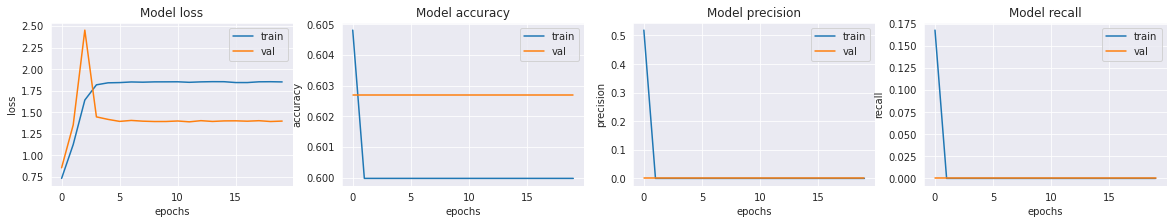

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet18_relu.history[met])
    ax[i].plot(history_resnet18_relu.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet18_relu.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

85/85 [==============================] - 2s 23ms/step - loss: 1.3786 - accuracy: 0.5996 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss of the model is -  1.3786379098892212
Accuracy of the model is -  59.95575189590454 %
Precision of the model is -  0.0
Recall of the model is -  0.0


## ResNet18V2 (DP-SGD)
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    preact = BatchNormalization(epsilon=1.001e-5, name=name + '_preact_bn')(x)
    preact = Activation('tanh', name=name + '_preact_tanh')(preact)
    if conv_shortcut is True:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = MaxPooling2D(1, strides=stride)(x) if stride > 1 else x
    x = Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = Activation('tanh', name=name + '_1_tanh')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = Activation('tanh', name=name + '_2_tanh')(x)
    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = Add(name=name + '_out')([shortcut, x])
    return x

def resnet_stack(x, filters, blocks, stride1=2, name=None):
    x = resnet_block(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = resnet_block(x, filters, name=name + '_block' + str(i))
    x = resnet_block(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet(stack_fn, input, model_name='resnet'):
    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(input)
    x = Conv2D(64, 7, strides=2, use_bias=True, name='conv1_conv')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = MaxPooling2D(3, strides=2, name='pool1_pool')(x)
    x = stack_fn(x)
    x = BatchNormalization(epsilon=1.001e-5, name='post_bn')(x)
    x = Activation('tanh', name='post_tanh')(x)
    # Create model
    model = tf.keras.models.Model(input, x, name=model_name)
    return model
    
def ResNet18V2(input):
    def stack_fn(x):
        x = resnet_stack(x, 16, 2, name='conv2') # original: 64
        x = resnet_stack(x, 32, 2, name='conv3')
        x = resnet_stack(x, 64, 2, name='conv4')
        x = resnet_stack(x, 128, 2, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, input, 'resnet18v2')

In [ ]:
def resnet18_builder():
    # get ResNet18V2 without head
    resnet18 = ResNet18V2(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])))
    
    model = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        resnet18, # add resnet18 to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet18V2')

    return model

In [ ]:
resnet18 = resnet18_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet18.compile(
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [ ]:
resnet18.summary()

Model: "ResNet18V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_7 (ModuleWrap (None, 8, 8, 512)         897088    
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 513       
Total params: 897,601
Trainable params: 891,713
Non-trainable params: 5,888
_________________________________________________________________


### Training

In [ ]:
history_resnet18 = resnet18.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


452/452 [==============================] - 169s 313ms/step - loss: 0.6676 - accuracy: 0.6216 - precision: 0.5315 - recall: 0.6253 - val_loss: 0.6677 - val_accuracy: 0.6094 - val_precision: 0.7143 - val_recall: 0.0281
Epoch 2/20
452/452 [==============================] - 141s 311ms/step - loss: 0.6949 - accuracy: 0.6647 - precision: 0.5717 - recall: 0.6348 - val_loss: 0.7275 - val_accuracy: 0.6295 - val_precision: 0.8750 - val_recall: 0.0787
Epoch 3/20
452/452 [==============================] - 141s 312ms/step - loss: 0.8680 - accuracy: 0.6642 - precision: 0.5788 - recall: 0.6197 - val_loss: 2.2839 - val_accuracy: 0.4129 - val_precision: 0.4032 - val_recall: 0.9944
Epoch 4/20
452/452 [==============================] - 141s 311ms/step - loss: 0.9195 - accuracy: 0.6794 - precision: 0.5935 - recall: 0.6401 - val_loss: 0.8593 - val_accuracy: 0.7009 - val_precision: 0.6100 - val_recall: 0.6854
Epoch 5/20
452/452 [==============================] - 141s 313ms/step - loss: 0.9535 - accuracy: 0.

### Evaluation

###### Visualize performance

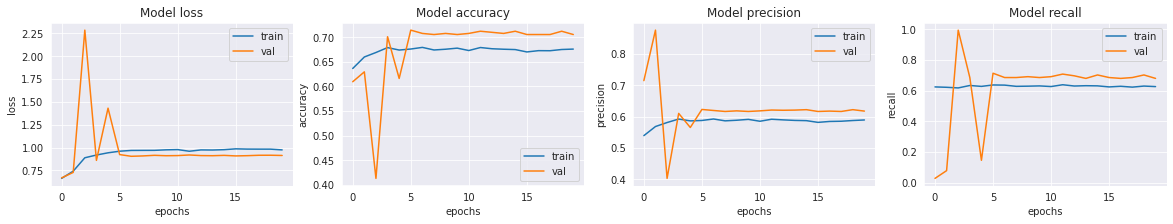

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet18.history[met])
    ax[i].plot(history_resnet18.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet18.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

85/85 [==============================] - 1s 14ms/step - loss: 0.9140 - accuracy: 0.7183 - precision: 0.6348 - recall: 0.6980
Loss of the model is -  0.914048433303833
Accuracy of the model is -  71.82890772819519 %
Precision of the model is -  0.6348408460617065
Recall of the model is -  0.6979742050170898


## ResNet18V2 logits
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    preact = BatchNormalization(epsilon=1.001e-5, name=name + '_preact_bn')(x)
    preact = Activation('tanh', name=name + '_preact_tanh')(preact)
    if conv_shortcut is True:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = MaxPooling2D(1, strides=stride)(x) if stride > 1 else x
    x = Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = Activation('tanh', name=name + '_1_tanh')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = Activation('tanh', name=name + '_2_tanh')(x)
    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = Add(name=name + '_out')([shortcut, x])
    return x

def resnet_stack(x, filters, blocks, stride1=2, name=None):
    x = resnet_block(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = resnet_block(x, filters, name=name + '_block' + str(i))
    x = resnet_block(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet(stack_fn, input, model_name='resnet'):
    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(input)
    x = Conv2D(64, 7, strides=2, use_bias=True, name='conv1_conv')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = MaxPooling2D(3, strides=2, name='pool1_pool')(x)
    x = stack_fn(x)
    x = BatchNormalization(epsilon=1.001e-5, name='post_bn')(x)
    x = Activation('tanh', name='post_tanh')(x)
    # Create model
    model = tf.keras.models.Model(input, x, name=model_name)
    return model
    
def ResNet18V2(input):
    def stack_fn(x):
        x = resnet_stack(x, 16, 2, name='conv2') # original: 64
        x = resnet_stack(x, 32, 2, name='conv3')
        x = resnet_stack(x, 64, 2, name='conv4')
        x = resnet_stack(x, 128, 2, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, input, 'resnet18v2')

In [ ]:
def resnet18_logits_builder():
    # get ResNet18V2 without head
    resnet18 = ResNet18V2(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])))
    
    model = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        resnet18, # add resnet18 to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet18V2-logits')

    return model

In [ ]:
resnet18_logits = resnet18_logits_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet18_logits.compile(
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=False,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [ ]:
resnet18_logits.summary()

Model: "ResNet18V2-logits"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_8 (ModuleWrap (None, 8, 8, 512)         897088    
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 513       
Total params: 897,601
Trainable params: 891,713
Non-trainable params: 5,888
_________________________________________________________________


### Training

In [ ]:
history_resnet18_logits = resnet18_logits.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20
452/452 [==============================] - 167s 312ms/step - loss: 0.6697 - accuracy: 0.6073 - precision: 0.5180 - recall: 0.5848 - val_loss: 0.6961 - val_accuracy: 0.5826 - val_precision: 0.4861 - val_recall: 0.8820
Epoch 2/20
452/452 [==============================] - 140s 311ms/step - loss: 0.6698 - accuracy: 0.6724 - precision: 0.5923 - recall: 0.6265 - val_loss: 1.4602 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
452/452 [==============================] - 140s 310ms/step - loss: 0.8026 - accuracy: 0.6711 - precision: 0.5877 - recall: 0.6221 - val_loss: 0.8083 - val_accuracy: 0.6451 - val_precision: 0.5336 - val_recall: 0.8483
Epoch 4/20
452/452 [==============================] - 141s 311ms/step - loss: 0.9310 - accuracy: 0.6796 - precision: 0.5965 - recall: 0.6350 - val_loss: 1.1340 - val_accuracy: 0.6830 - val_precision: 0.5667 - val_recall: 0.8596
Epoch 5/20
452/452 [==============================] - 141s 311ms/step - loss: 0.

### Evaluation

###### Visualize performance

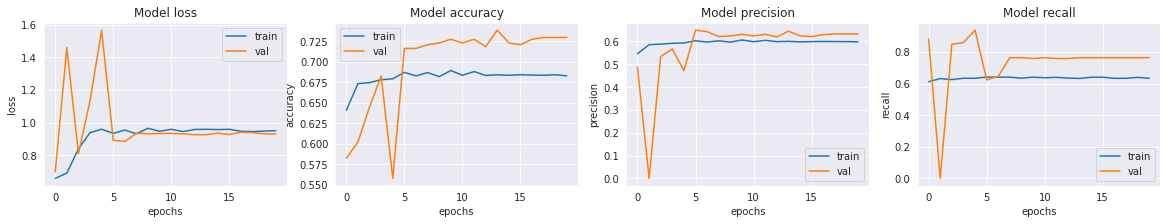

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet18_logits.history[met])
    ax[i].plot(history_resnet18_logits.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet18_logits.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

85/85 [==============================] - 1s 16ms/step - loss: 0.9329 - accuracy: 0.7205 - precision: 0.6302 - recall: 0.7311
Loss of the model is -  0.9328776597976685
Accuracy of the model is -  72.05014824867249 %
Precision of the model is -  0.6301587224006653
Recall of the model is -  0.7311233878135681


## ResNet18V2 - dropout
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    preact = BatchNormalization(epsilon=1.001e-5, name=name + '_preact_bn')(x)
    preact = Activation('tanh', name=name + '_preact_tanh')(preact)
    if conv_shortcut is True:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = MaxPooling2D(1, strides=stride)(x) if stride > 1 else x
    x = Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = Activation('tanh', name=name + '_1_tanh')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = Activation('tanh', name=name + '_2_tanh')(x)
    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = Add(name=name + '_out')([shortcut, x])
    return x

def resnet_stack(x, filters, blocks, stride1=2, name=None):
    x = resnet_block(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = resnet_block(x, filters, name=name + '_block' + str(i))
    x = resnet_block(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet(stack_fn, input, model_name='resnet'):
    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(input)
    x = Conv2D(64, 7, strides=2, use_bias=True, name='conv1_conv')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = MaxPooling2D(3, strides=2, name='pool1_pool')(x)
    x = stack_fn(x)
    x = BatchNormalization(epsilon=1.001e-5, name='post_bn')(x)
    x = Activation('tanh', name='post_tanh')(x)
    # Create model
    model = tf.keras.models.Model(input, x, name=model_name)
    return model
    
def ResNet18V2(input):
    def stack_fn(x):
        x = resnet_stack(x, 16, 2, name='conv2') # original: 64
        x = resnet_stack(x, 32, 2, name='conv3')
        x = resnet_stack(x, 64, 2, name='conv4')
        x = resnet_stack(x, 128, 2, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, input, 'resnet18v2')

In [ ]:
def resnet18_drop_builder():
    # ResNet18V2 without head
    resnet18 = ResNet18V2(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])))
    model = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        resnet18, # add resnet18 to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dropout(0.2, name='Dropout'), # add dropout (inspired by inception-resnet-v2)
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet18V2-drop')
    
    return model

In [ ]:
resnet18_drop = resnet18_drop_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet18_drop.compile(
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [ ]:
resnet18_drop.summary()

Model: "ResNet18V2-drop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_9 (ModuleWrap (None, 8, 8, 512)         897088    
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 512)               0         
_________________________________________________________________
Dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 513       
Total params: 897,601
Trainable params: 891,713
Non-trainable params: 5,888
_________________________________________________________________


### Training

In [ ]:
history_resnet18_drop = resnet18_drop.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


452/452 [==============================] - 170s 314ms/step - loss: 0.6716 - accuracy: 0.6125 - precision: 0.5186 - recall: 0.6277 - val_loss: 0.7606 - val_accuracy: 0.5670 - val_precision: 0.4759 - val_recall: 0.8876
Epoch 2/20
452/452 [==============================] - 141s 311ms/step - loss: 0.7232 - accuracy: 0.6554 - precision: 0.5665 - recall: 0.6419 - val_loss: 1.2368 - val_accuracy: 0.5045 - val_precision: 0.4412 - val_recall: 0.9270
Epoch 3/20
452/452 [==============================] - 141s 312ms/step - loss: 0.8428 - accuracy: 0.6668 - precision: 0.5830 - recall: 0.6496 - val_loss: 2.7804 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
452/452 [==============================] - 141s 312ms/step - loss: 0.9112 - accuracy: 0.6760 - precision: 0.5922 - recall: 0.6577 - val_loss: 1.2916 - val_accuracy: 0.6339 - val_precision: 0.5233 - val_recall: 0.8820
Epoch 5/20
452/452 [==============================] - 141s 311ms/step - loss: 0.9507 - accu

### Evaluation

###### Visualize performance

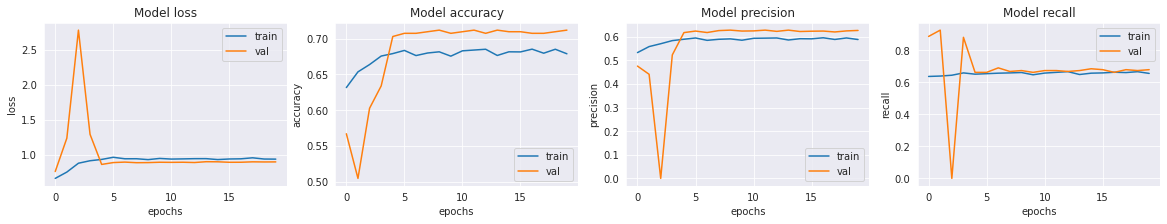

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet18_drop.history[met])
    ax[i].plot(history_resnet18_drop.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet18_drop.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

85/85 [==============================] - 1s 17ms/step - loss: 0.8931 - accuracy: 0.7139 - precision: 0.6329 - recall: 0.6796
Loss of the model is -  0.893085241317749
Accuracy of the model is -  71.38643264770508 %
Precision of the model is -  0.6329330801963806
Recall of the model is -  0.6795580387115479


## ResNet18V2 pneu
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    preact = BatchNormalization(epsilon=1.001e-5, name=name + '_preact_bn')(x)
    preact = Activation('tanh', name=name + '_preact_tanh')(preact)
    if conv_shortcut is True:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = MaxPooling2D(1, strides=stride)(x) if stride > 1 else x
    x = Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = Activation('tanh', name=name + '_1_tanh')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = Activation('tanh', name=name + '_2_tanh')(x)
    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = Add(name=name + '_out')([shortcut, x])
    return x

def resnet_stack(x, filters, blocks, stride1=2, name=None):
    x = resnet_block(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = resnet_block(x, filters, name=name + '_block' + str(i))
    x = resnet_block(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet(stack_fn, input, model_name='resnet'):
    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(input)
    x = Conv2D(64, 7, strides=2, use_bias=True, name='conv1_conv')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = MaxPooling2D(3, strides=2, name='pool1_pool')(x)
    x = stack_fn(x)
    x = BatchNormalization(epsilon=1.001e-5, name='post_bn')(x)
    x = Activation('tanh', name='post_tanh')(x)
    # Create model
    model = tf.keras.models.Model(input, x, name=model_name)
    return model
    
def ResNet18V2(input):
    def stack_fn(x):
        x = resnet_stack(x, 16, 2, name='conv2') # original: 64
        x = resnet_stack(x, 32, 2, name='conv3')
        x = resnet_stack(x, 64, 2, name='conv4')
        x = resnet_stack(x, 128, 2, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, input, 'resnet18v2')

In [ ]:
def resnet18_pneu_builder():
    # ResNet18V2 without head
    resnet18 = ResNet18V2(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])))
    model = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        resnet18, # add resnet18 to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet18V2-pneu')
    
    return model

In [ ]:
resnet18_pneu = resnet18_pneu_builder()

# load weights from pneumonia pretraining
resnet18_pneu.load_weights(weights_path+'resnet18_tanh_public_weights.h5')

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet18_pneu.compile(
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [ ]:
resnet18_pneu.summary()

Model: "ResNet18V2-pneu"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_10 (ModuleWra (None, 8, 8, 512)         897088    
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 513       
Total params: 897,601
Trainable params: 891,713
Non-trainable params: 5,888
_________________________________________________________________


### Training

In [ ]:
history_resnet18_pneu = resnet18_pneu.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


452/452 [==============================] - 169s 313ms/step - loss: 0.9828 - accuracy: 0.6770 - precision: 0.5802 - recall: 0.7393 - val_loss: 2.2922 - val_accuracy: 0.6339 - val_precision: 0.8500 - val_recall: 0.0955
Epoch 2/20
452/452 [==============================] - 141s 311ms/step - loss: 1.2046 - accuracy: 0.7093 - precision: 0.6159 - recall: 0.7464 - val_loss: 2.3460 - val_accuracy: 0.6161 - val_precision: 0.5093 - val_recall: 0.9213
Epoch 3/20
452/452 [==============================] - 141s 311ms/step - loss: 1.1939 - accuracy: 0.7200 - precision: 0.6330 - recall: 0.7407 - val_loss: 1.2480 - val_accuracy: 0.7121 - val_precision: 0.7130 - val_recall: 0.4607
Epoch 4/20
452/452 [==============================] - 141s 311ms/step - loss: 1.2122 - accuracy: 0.7129 - precision: 0.6276 - recall: 0.7312 - val_loss: 3.0495 - val_accuracy: 0.5246 - val_precision: 0.4528 - val_recall: 0.9438
Epoch 5/20
452/452 [==============================] - 141s 312ms/step - loss: 1.1474 - accuracy: 0.

### Evaluation

###### Visualize performance

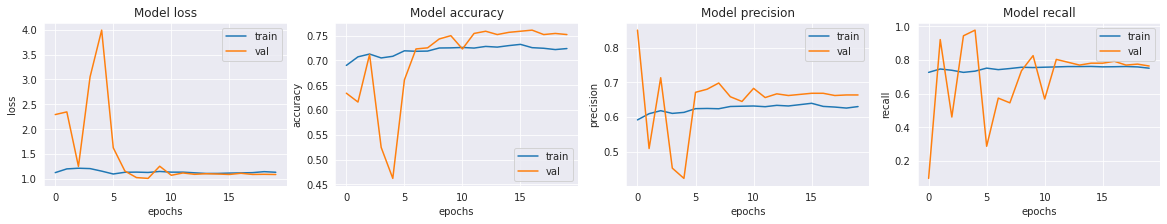

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet18_pneu.history[met])
    ax[i].plot(history_resnet18_pneu.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet18_pneu.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

85/85 [==============================] - 1s 14ms/step - loss: 1.0667 - accuracy: 0.7633 - precision: 0.6802 - recall: 0.7716
Loss of the model is -  1.0666837692260742
Accuracy of the model is -  76.32743120193481 %
Precision of the model is -  0.6801947951316833
Recall of the model is -  0.7716390490531921


## Evaluation

In [ ]:
models = [
    resnet18_relu,
    resnet18,
    resnet18_logits,
    resnet18_drop,
    resnet18_pneu,
]

### Model Analysis

In [ ]:
for model in models:
    print("Evaluating %s ..." % (model.name))
    loss, acc, prec, rec = model.evaluate(test_batched)
    print('\n')

Evaluating ResNet18V2-relu ...
85/85 [==============================] - 1s 14ms/step - loss: 1.3786 - accuracy: 0.5996 - precision: 0.0000e+00 - recall: 0.0000e+00


Evaluating ResNet18V2 ...
85/85 [==============================] - 1s 15ms/step - loss: 0.9140 - accuracy: 0.7183 - precision: 0.6348 - recall: 0.6980


Evaluating ResNet18V2-logits ...
85/85 [==============================] - 1s 14ms/step - loss: 0.9329 - accuracy: 0.7205 - precision: 0.6302 - recall: 0.7311


Evaluating ResNet18V2-drop ...
85/85 [==============================] - 1s 14ms/step - loss: 0.8931 - accuracy: 0.7139 - precision: 0.6329 - recall: 0.6796


Evaluating ResNet18V2-pneu ...
85/85 [==============================] - 1s 14ms/step - loss: 1.0667 - accuracy: 0.7633 - precision: 0.6802 - recall: 0.7716




### Privacy Analysis

#### Compute epsilon

In [ ]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [ ]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [ ]:
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-04, Epsilon = 1.000


In [ ]:
# get needed noise for target epsilon
min_noise = 1e-5
target_epsilon = 1.0
noise = compute_noise(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    target_epsilon,
    EPOCHS,
    DELTA,
    min_noise
)
print(noise)

DP-SGD with sampling rate = 0.221% and noise_multiplier = 1.020921289099455 iterated over 9040 steps satisfies differential privacy with eps = 1 and delta = 0.0001.
1.020921289099455


#### Membership Inference Attack

In [ ]:
def compute_attack_inputs(attack_data):
    bc = tf.keras.backend.binary_crossentropy
    constant = tf.keras.backend.constant
    # get labels
    labels = []
    for x, y in attack_data.as_numpy_iterator():
        labels.append(y[0])
    # predict
    probs = model.predict(attack_data)
    # compute loss
    losses = np.array([x[0] for x in bc(constant([[y] for y in labels]), constant(probs), from_logits=False).numpy()])
    
    return (np.array(probs), np.array(losses), np.array(labels))

# run membership inference attack
def run_mia(model, train_attack_input, test_attack_input):
    # prepare attacks
    probs_train, loss_train, labels_train = train_attack_input
    probs_test, loss_test, labels_test = test_attack_input

    attack_input = AttackInputData(
        probs_train = probs_train,
        probs_test = probs_test,
        loss_train = loss_train,
        loss_test = loss_test,
        labels_train = labels_train,
        labels_test = labels_test
    )

    slicing_spec = SlicingSpec(
        entire_dataset = True,
        by_class = True,
        by_percentiles = False,
        by_classification_correctness = True
    )

    attack_types = [
        #AttackType.THRESHOLD_ATTACK, # logistic was always better, so no threshold to save time
        AttackType.LOGISTIC_REGRESSION,
    ] 

    # run several attacks for different data slices
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                     slicing_spec=slicing_spec,
                                     attack_types=attack_types)

    # plot the ROC curve of the best classifier
    #plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)
    #plt.show()

    # print a user-friendly summary of the attacks
    #print(attacks_result.summary(by_slices=False))

    max_auc = attacks_result.get_result_with_max_auc().get_auc()
    max_adv = attacks_result.get_result_with_max_attacker_advantage().get_attacker_advantage()

    return max_auc, max_adv

# epsilon estimation based on attack, metric adapted for AUC from https://paperswithcode.com/paper/antipodes-of-label-differential-privacy-pate
def empirical_eps(auc):
    if auc <= 0.5:
        return 0
    if auc == 1:
        return np.inf
    return np.log(auc / (1 - auc))

from contextlib import contextmanager
import sys
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [ ]:
import scipy.stats as st

for model in models:
    print('Membership Inference Attack on '+model.name+'...')
    SAMPLE_NB = 100
    
    train_attack_input = compute_attack_inputs(train_attack_data)
    test_attack_input = compute_attack_inputs(test_attack_data)

    aucs = []
    advs = []
    emp_eps = []
    for i in range(SAMPLE_NB):
        with suppress_stdout():
            max_auc, max_adv = run_mia(model, train_attack_input, test_attack_input)
        aucs.append(max_auc)
        advs.append(max_adv)
        emp_eps.append(empirical_eps(max_auc))

    auc_low, auc_high = st.t.interval(0.95, len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs))
    adv_low, adv_high = st.t.interval(0.95, len(advs)-1, loc=np.mean(advs), scale=st.sem(advs))
    eps_low, eps_high = st.t.interval(0.95, len(emp_eps)-1, loc=np.mean(emp_eps), scale=st.sem(emp_eps))

    print('95%%-CI based on %i attack samples'%(SAMPLE_NB))
    print('AUC: %0.2f-%0.2f'%(auc_low, auc_high))
    print('Attacker advantage: %0.2f-%0.2f'%(adv_low, adv_high))
    print('Empirical epsilon bounds from AUC: %0.2f-%0.2f\n'%(eps_low, eps_high))

Membership Inference Attack on ResNet18V2-relu...
95%-CI based on 100 attack samples
AUC: 0.53-0.54
Attacker advantage: 0.12-0.13
Empirical epsilon bounds from AUC: 0.12-0.16

Membership Inference Attack on ResNet18V2...
95%-CI based on 100 attack samples
AUC: 0.54-0.55
Attacker advantage: 0.13-0.14
Empirical epsilon bounds from AUC: 0.17-0.20

Membership Inference Attack on ResNet18V2-logits...
95%-CI based on 100 attack samples
AUC: 0.53-0.54
Attacker advantage: 0.13-0.14
Empirical epsilon bounds from AUC: 0.13-0.17

Membership Inference Attack on ResNet18V2-drop...
95%-CI based on 100 attack samples
AUC: 0.54-0.55
Attacker advantage: 0.13-0.14
Empirical epsilon bounds from AUC: 0.16-0.19

Membership Inference Attack on ResNet18V2-pneu...
95%-CI based on 100 attack samples
AUC: 0.55-0.56
Attacker advantage: 0.13-0.15
Empirical epsilon bounds from AUC: 0.19-0.23

